## Module 3 lab - KMeans Clustering

We have discussed clustering in Statmath course. You can [revisit the course here](https://jupyterhub.dsa.missouri.edu/user/skaf48/tree/DSA-8610/modules/module7). As an unsupervised data analysis technique, It organises data objects by proximity based on its variables and helps to create natural groupings for a set of data objects. By grouping data one can understand how each data point relates to each other and discover groups of similar ones. 

When the groups are formed, centroids can be defined for them, the ideal data object that minimises the sum of the distances to each of the data points in a cluster. By analysing these centroids variables we will be able to define each cluster in terms of its characteristics.

In this notebook, the dataset is related to deaths from Infectious Tuberculosis disease in each country from 1990 to 2007. The data is available on [gapminder website](http://www.gapminder.org/data/) which is a comprehensive resource for data regarding different countries and territories indicators. We will work with data where each sample is a country and each variable is a year. 

Kmeans clustering divides set of data objects into k clusters, assigning each observation to a cluster so as to minimize the distance of that observation (in n-dimensional space) to the cluster’s mean; the means are then recomputed. This operation is run iteratively until the clusters converge, for a maximum of number of iterations chosen. Given a target number, k, of clusters to find, it will locate the centers of each of those k clusters and the boundaries between them. It does this using the following algorithm:

1. Start with a randomly selected set of  k  centroids (the supposed centers of the  k  clusters)
2. Determine which observation is in which cluster, based on which centroid it is closest to (using the squared Euclidean distance:  ∑pj=1(xij−xi′j)2  where  p  is the number of dimensions)
3. Re-calculate the centroids of each cluster by minimizing the squared Euclidean distance to each observation in the cluster
4. Repeat 2. and 3. until the members of the clusters (and hence the positions of the centroids) no longer change.

In [1]:
import pandas as pd

tb_deaths_per_100k = pd.read_csv("../../../datasets/TB/tb_deaths_per_100k.csv",index_col = 0, thousands  = ',')
tb_deaths_per_100k.index.names = ['country']
tb_deaths_per_100k.columns.names = ['year']
tb_deaths_per_100k

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,Unnamed: 19
country,,,,,,,,,,,,,,,,,,,
Afghanistan,50.0,49.0,48.0,47.0,47.0,46.0,46.0,45.0,43.0,43.0,41.0,39.0,36.0,37.0,34.0,33.0,31.0,30.0,NaN
Albania,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,NaN
Algeria,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
American Samoa,5.0,2.0,0.0,2.0,2.0,2.0,0.0,9.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
Andorra,4.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,NaN
Angola,60.0,60.0,61.0,62.0,63.0,64.0,66.0,48.0,56.0,53.0,75.0,49.0,34.0,30.0,37.0,39.0,29.0,33.0,NaN
Anguilla,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN
Antigua and Barbuda,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
Argentina,8.0,8.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0,6.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0,NaN


An extra row of NANs' is introduced. Get rid of that row using pandas indexing as shown below. Also get rid of the extra column "Unnames: 19" that is introduced at the end. 

In [2]:
# Exclude last row of data
tb_deaths_per_100k = tb_deaths_per_100k[:-1]

# Exclude last column with NANs'
del tb_deaths_per_100k["Unnamed: 19"]

In [3]:
tb_deaths_per_100k

year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007
country,,,,,,,,,,,,,,,,,,
Afghanistan,50.0,49.0,48.0,47.0,47.0,46.0,46.0,45.0,43.0,43.0,41.0,39.0,36.0,37.0,34.0,33.0,31.0,30.0
Albania,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
Algeria,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
American Samoa,5.0,2.0,0.0,2.0,2.0,2.0,0.0,9.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
Andorra,4.0,4.0,4.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0
Angola,60.0,60.0,61.0,62.0,63.0,64.0,66.0,48.0,56.0,53.0,75.0,49.0,34.0,30.0,37.0,39.0,29.0,33.0
Anguilla,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
Antigua and Barbuda,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Argentina,8.0,8.0,7.0,7.0,7.0,7.0,6.0,6.0,6.0,6.0,5.0,6.0,5.0,5.0,5.0,5.0,5.0,4.0


Kmeans takes set of data points and clusters them in specified number of groups. The data here has 18 variables. Use PCA to reduce the dimensions of the data. Python's sklearn machine learning library comes with a PCA implementation. 

For very large dimensional data, normal PCA implementation may not work. We should consider apache Spark's dimensionality reduction features that is explored in Database Analytics course last semester. In this case, there are just 18 variables. Its a small feature set for today's machine learning libraries and computer capabilities. So we are ok. Specify in advance the number of principal components we want to use. Call the fit() method on the data frame.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(tb_deaths_per_100k)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [5]:
deaths_pca = pca.transform(tb_deaths_per_100k)

Create a dataframe using the two principal components generated.  

In [6]:
# Create a dataframe with the two principal components generated. 
deaths_pca_df = pd.DataFrame(deaths_pca)

# Assign the indexes of tb_deaths_per_100 to deaths_pca_df. tb_deaths_per_100 has country names as its indexes. So they both
# will have same indexes now.
deaths_pca_df.index = tb_deaths_per_100k.index

# Rename the column names of deaths_pca_df to something meaningful. 
deaths_pca_df.columns = ['PC1','PC2']
deaths_pca_df.head()

,PC1,PC2
country,,
Afghanistan,51.817943,-41.930763
Albania,-99.541156,8.694757
Algeria,-108.470846,11.361761
American Samoa,-110.172725,8.275184
Andorra,-105.472595,8.233806


You can look at explained variance ratio by each principal component as follows.

In [7]:
print(pca.explained_variance_ratio_) 

[ 0.90647563  0.05727867]


The first component explains over 90% of the variance, while the second one accounts for nearly 6% for a total of almost 96% between the two of them.

Now that a lower dimensionality version of data is ready, call plot function on the data frame, by passing the kind of plot you want and what columns correspond to each axis. The for loop below adds an annotation to tag country with a point.

**Reference: ** [enumerate()](http://book.pythontips.com/en/latest/enumerate.html): It allows to loop over a list and have an automatic counter and value for corresponding to . Here is an example:

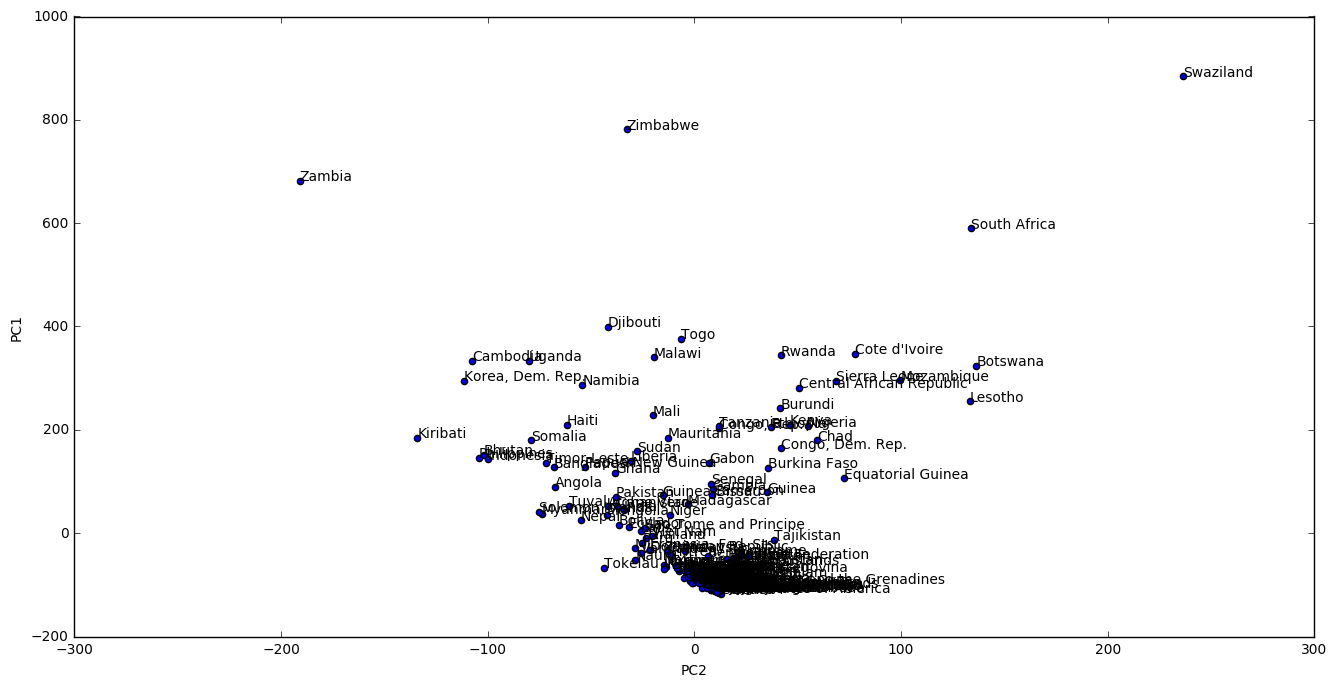

In [8]:
%matplotlib inline

ax = deaths_pca_df.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, country in enumerate(deaths_pca_df.index):
    ax.annotate(country, (deaths_pca_df.iloc[i].PC2, deaths_pca_df.iloc[i].PC1))

Create a bubble chart, by setting the point size to a value proportional to the mean value for all the years in that particular country. First of all, a new column containing the re-scaled mean per country across all the years should be added.

In [9]:
# from sklearn.preprocessing import normalize

deaths_pca_df['country_mean'] = pd.Series(tb_deaths_per_100k.mean(axis=1), index=tb_deaths_per_100k.index)
country_mean_max = deaths_pca_df['country_mean'].max()
country_mean_min = deaths_pca_df['country_mean'].min()
country_mean_scaled = (deaths_pca_df.country_mean-country_mean_min) / country_mean_max

deaths_pca_df['country_mean_scaled'] = pd.Series(country_mean_scaled, index=deaths_pca_df.index) 
deaths_pca_df.head()

,PC1,PC2,country_mean,country_mean_scaled
country,,,,
Afghanistan,51.817943,-41.930763,41.388889,0.186297
Albania,-99.541156,8.694757,4.166667,0.018755
Algeria,-108.470846,11.361761,2.000000,0.009002
American Samoa,-110.172725,8.275184,1.722222,0.007752
Andorra,-105.472595,8.233806,2.833333,0.012753


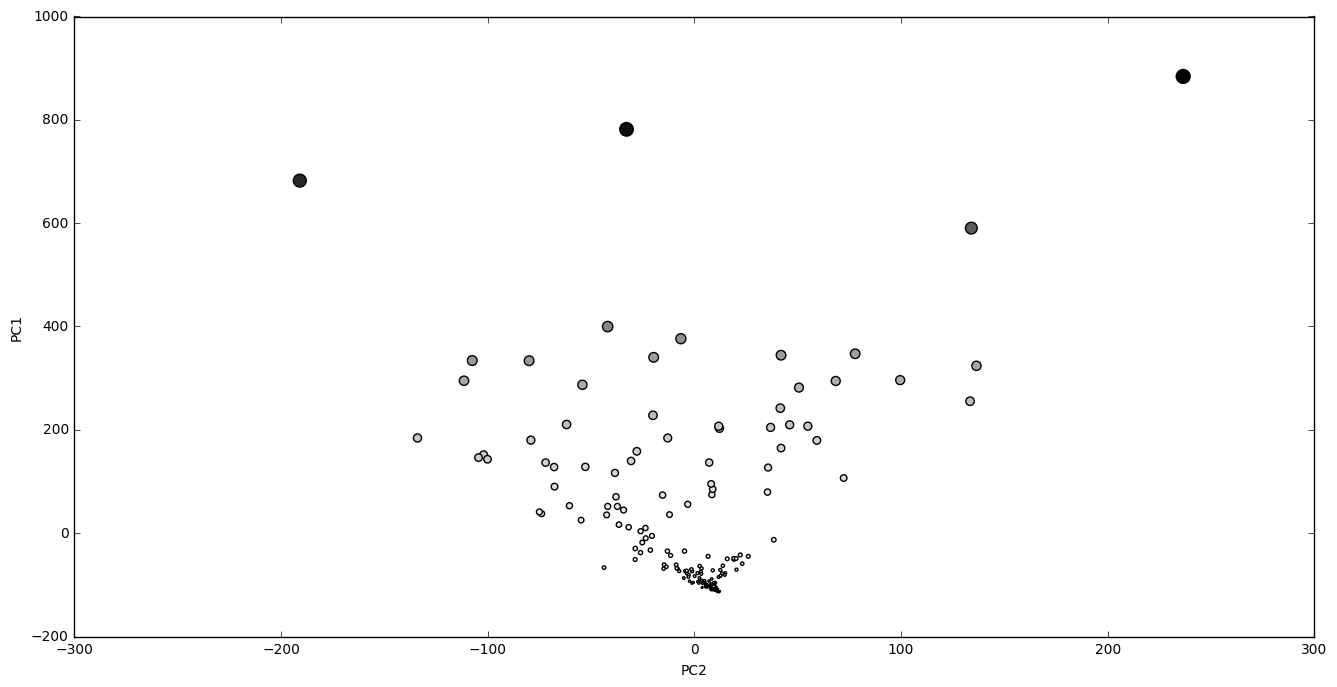

In [10]:
deaths_pca_df.plot(kind='scatter', x='PC2', y='PC1', s=deaths_pca_df['country_mean_scaled']*100, figsize=(16,8), c=deaths_pca_df['country_mean_scaled'])

Above plots suggest that most variation happens along the y axis which is PC1. At the bottom of the chart there is concentration of countries that are mostly developed. When ascending the axis, the number of countries is becoming more sparse and they belong to less developed regions of the world.

When the points are coloured and sized using the magnitude average, the directions also correspond to a variation in these magnitudes.

PCA did tell us something about the data. How it is varying over all in the dataset. WE still dont know the relationships between countries. We will use k-means clustering to group countries based on how similar their situation has been year-by-year. Then we will use cluster assignment to colour code previous scatter plot that we generated.

When using k-means, the most important thing to do id to determine the right number of group for the data. This can be done more or less accurately by iterating through different values for the number of groups and compare an amount called the within-cluster sum of square distances for each iteration. This is the squared sum of distances to the cluster center for each cluster member. Of course this distance is minimal when the number of clusters gets equal to the number of samples, but we don't want to get there. We normally stop when the improvement in this value starts decreasing at a lower rate.

##### silhouette score

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object lies within its cluster - from wikipedia.org. The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. It will tell us whats is the optimum number of clsuters for given data. 

**Reference: **
- [sklearn.metrics.silhouette_score¶](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
- [Silhouette (clustering)](https://en.wikipedia.org/wiki/Silhouette_(clustering))

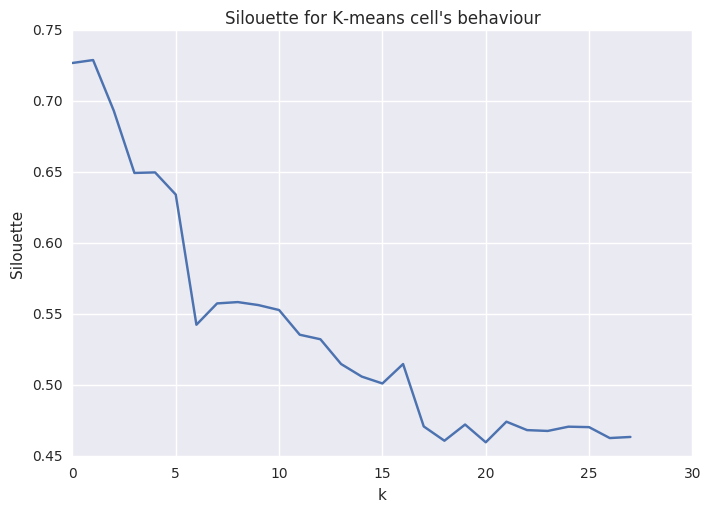

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

s = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(deaths_pca_df)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    s.append(silhouette_score(deaths_pca_df, labels, metric='euclidean'))

plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

The silhouette ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. So we need to choose an optimum value. Lets start with 3 clusters.

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(tb_deaths_per_100k)

Store the cluster assignments together with each country in data frame. The cluster labels are returned in clusters.labels_.

In [13]:
deaths_pca_df['cluster'] = pd.Series(clusters.labels_, index=deaths_pca_df.index)

And now we are ready to plot, using the cluster column as color.

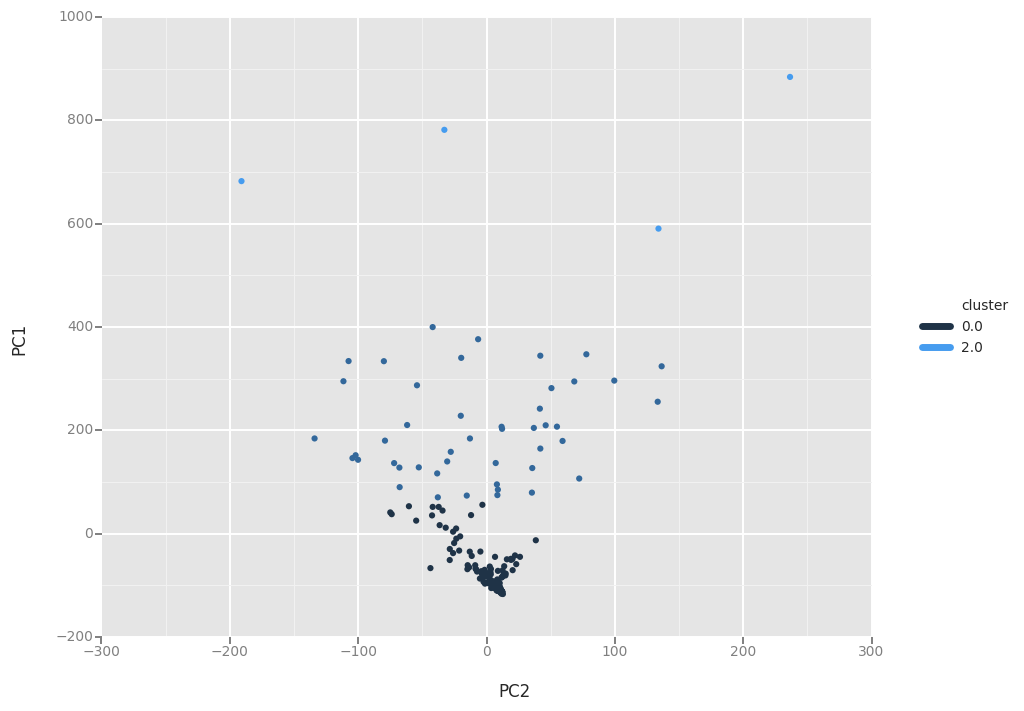

<ggplot: (8743323016077)>

In [14]:
import numpy as np
from ggplot import *

# deaths_pca_df.plot(kind='scatter', x='PC2',y='PC1',c=deaths_pca_df.cluster.astype(np.float), figsize=(16,8))

# for i, country in enumerate(deaths_pca_df.index):
#     ax.annotate(cluster, (deaths_pca_df.iloc[i].PC2, deaths_pca_df.iloc[i].PC1))
    
ggplot(deaths_pca_df, aes(x='PC2', y='PC1', color='cluster')) + geom_point()

In [15]:
tab = deaths_pca_df.groupby(['cluster']).size()
tab

cluster
0    157
1     46
2      4
dtype: int64

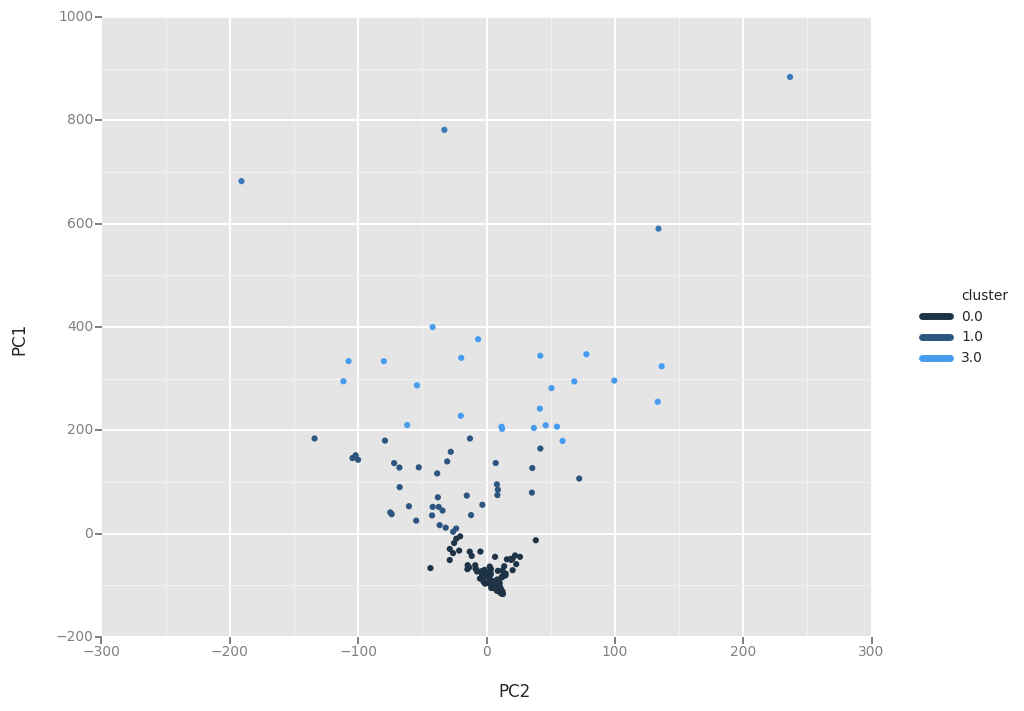

<ggplot: (8743312152184)>

In [16]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit(tb_deaths_per_100k)

deaths_pca_df['cluster'] = pd.Series(clusters.labels_, index=deaths_pca_df.index)

ggplot(deaths_pca_df, aes(x='PC2', y='PC1', color='cluster')) + geom_point()

In [17]:
tab = deaths_pca_df.groupby(['cluster']).size()
tab

cluster
0    143
1     37
2      4
3     23
dtype: int64

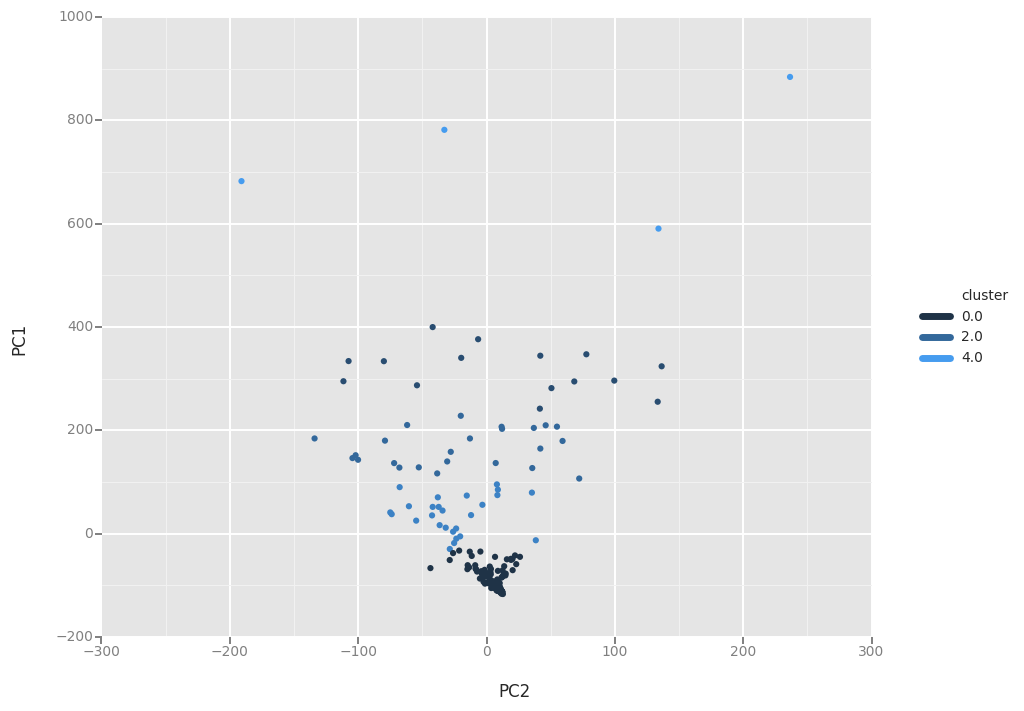

<ggplot: (8743312437487)>

In [18]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit(tb_deaths_per_100k)
centroids = kmeans.cluster_centers_

deaths_pca_df['cluster'] = pd.Series(clusters.labels_, index=deaths_pca_df.index)

ggplot(deaths_pca_df, aes(x='PC2', y='PC1', color='cluster')) + geom_point()

In [19]:
tab = deaths_pca_df.groupby(['cluster']).size()
tab

cluster
0    138
1     15
2     24
3     26
4      4
dtype: int64

##### Interpreting cluster assignments

Cluster 1 contains 37 countries and the centroid of the cluster is shown below.

In [20]:
centroids[0]

array([ 6.86956522,  6.94927536,  6.7173913 ,  6.7826087 ,  6.55072464,
        6.91304348,  6.23188406,  6.50724638,  6.39855072,  6.47101449,
        5.68115942,  5.6884058 ,  6.4057971 ,  5.50724638,  5.49275362,
        5.1884058 ,  5.22463768,  4.97101449])

In [21]:
print(deaths_pca_df.loc[deaths_pca_df['cluster']==0].shape)
deaths_pca_df[deaths_pca_df['cluster'] == 0].index.tolist()

(138, 5)


['Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bosnia and Herzegovina',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Canada',
 'Cayman Islands',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Dominica',
 'Dominican Republic',
 'Egypt',
 'El Salvador',
 'Eritrea',
 'Estonia',
 'Fiji',
 'Finland',
 'France',
 'French Polynesia',
 'Georgia',
 'Germany',
 'Greece',
 'Grenada',
 'Guam',
 'Guatemala',
 'Guyana',
 'Honduras',
 'Hungary',
 'Iceland',
 'Iran',
 'Iraq',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Kuwait',
 'Kyrgyzstan',
 'Latvia',
 'Lebanon',
 'Libyan Arab Jamahiriya',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'M

Cluster 2 contains 143 countries and the centroid of the cluster is shown below.

In [22]:
centroids[1]

array([  68.66666667,   75.8       ,   80.53333333,   85.6       ,
         90.06666667,   94.13333333,   84.4       ,   85.8       ,
         92.6       ,  107.        ,  104.66666667,  109.66666667,
        116.6       ,  121.13333333,  123.2       ,  124.13333333,
        121.2       ,  129.13333333])

In [23]:
print(deaths_pca_df.loc[deaths_pca_df['cluster']==1].shape)
deaths_pca_df[deaths_pca_df['cluster'] == 1].index.tolist()

(15, 5)


['Botswana',
 'Burundi',
 'Cambodia',
 'Central African Republic',
 "Cote d'Ivoire",
 'Korea, Dem. Rep.',
 'Djibouti',
 'Lesotho',
 'Malawi',
 'Mozambique',
 'Namibia',
 'Rwanda',
 'Sierra Leone',
 'Togo',
 'Uganda']

Cluster 3 contains just 1 country and the centroid of the cluster is shown below.

In [25]:
centroids[2]

array([ 60.20833333,  60.95833333,  61.58333333,  62.70833333,
        63.70833333,  64.75      ,  66.75      ,  68.75      ,
        67.70833333,  70.83333333,  69.875     ,  71.25      ,
        71.58333333,  73.45833333,  69.08333333,  69.08333333,
        67.625     ,  67.95833333])

In [24]:
print(deaths_pca_df.loc[deaths_pca_df['cluster']==2].shape)
deaths_pca_df[deaths_pca_df['cluster'] == 2].index.tolist()

(24, 5)


['Bangladesh',
 'Bhutan',
 'Burkina Faso',
 'Chad',
 'Congo, Rep.',
 'Congo, Dem. Rep.',
 'Equatorial Guinea',
 'Ethiopia',
 'Gabon',
 'Ghana',
 'Haiti',
 'Indonesia',
 'Kenya',
 'Kiribati',
 'Liberia',
 'Mali',
 'Mauritania',
 'Nigeria',
 'Papua New Guinea',
 'Philippines',
 'Somalia',
 'Sudan',
 'Timor-Leste',
 'Tanzania']

Cluster 4 contains 23 countries and the centroid of the cluster is shown below.

In [26]:
centroids[3]

array([ 42.        ,  41.30769231,  40.57692308,  40.11538462,
        39.76923077,  39.53846154,  38.76923077,  38.07692308,
        38.23076923,  38.84615385,  38.57692308,  36.88461538,
        35.38461538,  34.23076923,  33.76923077,  32.92307692,
        31.96153846,  31.76923077])

In [27]:
print(deaths_pca_df.loc[deaths_pca_df['cluster']==3].shape)
deaths_pca_df[deaths_pca_df['cluster'] == 3].index.tolist()

(26, 5)


['Afghanistan',
 'Angola',
 'Bolivia',
 'Cameroon',
 'Cape Verde',
 'Ecuador',
 'Gambia',
 'Guinea',
 'Guinea-Bissau',
 'India',
 'Laos',
 'Madagascar',
 'Micronesia, Fed. Sts.',
 'Mongolia',
 'Myanmar',
 'Nepal',
 'Niger',
 'Pakistan',
 'Peru',
 'Sao Tome and Principe',
 'Senegal',
 'Solomon Islands',
 'Tajikistan',
 'Thailand',
 'Tuvalu',
 'Viet Nam']

Cluster 5 contains 3 countries and the centroid of the cluster is shown below.

In [28]:
centroids[4]

array([ 105.75,  118.75,  131.5 ,  151.  ,  163.25,  176.75,  191.5 ,
        208.25,  193.75,  216.5 ,  246.25,  274.75,  200.75,  214.25,
        225.  ,  239.75,  237.5 ,  231.75])

In [29]:
print(deaths_pca_df.loc[deaths_pca_df['cluster']==4].shape)
deaths_pca_df[deaths_pca_df['cluster'] == 4].index.tolist()

(4, 5)


['South Africa', 'Swaziland', 'Zambia', 'Zimbabwe']